# Slot Attention × MOVi-A（フレーム抽出）再現ベースライン

保存するもの（比較のため必須）：
- results/<RUN_NAME>/<timestamp>/
  - config.json
  - metrics.csv              (step, train_loss, lr, val_loss, ari(optional))
  - loss_curve.png           (損失曲線)
  - recon_stepXXXXXX.png     (固定バッチ: input/recon/slot分解)


## インストール

In [1]:
!pip -q install -U tensorflow-datasets tensorflow-io-gcs-filesystem einops matplotlib tqdm
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121
print("done")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 75.8 MB/s eta 0:00:00
done


## import・乱数固定・GPU確認

In [2]:
import os, time, json, math, random
import numpy as np
import tensorflow_datasets as tfds

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader

from einops import rearrange
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device, "cuda:", torch.cuda.is_available())
print("torch:", torch.__version__)
print("tfds:", tfds.__version__)

device: cuda cuda: True
torch: 2.9.0+cu126
tfds: 4.9.9


## MOVi-A をロード

In [3]:
DATASET_NAME = "kubric:movi_a"

# 公開GCSの生成済みTFDSを複数バージョン候補で探索
GCS_BASE = "gs://kubric-public/tfds/movi_a"
GCS_VERSION_CANDIDATES = ["1.0.0", "1.0.1", "1.0.2", "1.1.0", "1.2.0"]

def try_builder_from_gcs():
    for ver in GCS_VERSION_CANDIDATES:
        gcs_dir = f"{GCS_BASE}/{ver}"
        try:
            b = tfds.builder_from_directory(gcs_dir)
            print(f"[OK] builder_from_directory: {gcs_dir}")
            return b
        except Exception as e:
            print(f"[NG] {gcs_dir} -> {type(e).__name__}: {e}")
    return None

builder = try_builder_from_gcs()

if builder is None:
    print("\nGCSから読めないため、ローカルで download_and_prepare() します（初回は重いです）")
    builder = tfds.builder(DATASET_NAME)
    builder.download_and_prepare()

info = builder.info
print("\n=== Dataset Info ===")
print("splits:", list(info.splits.keys()))
print("features:", info.features)

[NG] gs://kubric-public/tfds/movi_a/1.0.0 -> DatasetInfoFileError: Could not read dataset info from gs://kubric-public/tfds/movi_a/1.0.0/dataset_info.json
[NG] gs://kubric-public/tfds/movi_a/1.0.1 -> DatasetInfoFileError: Could not read dataset info from gs://kubric-public/tfds/movi_a/1.0.1/dataset_info.json
[NG] gs://kubric-public/tfds/movi_a/1.0.2 -> DatasetInfoFileError: Could not read dataset info from gs://kubric-public/tfds/movi_a/1.0.2/dataset_info.json
[NG] gs://kubric-public/tfds/movi_a/1.1.0 -> DatasetInfoFileError: Could not read dataset info from gs://kubric-public/tfds/movi_a/1.1.0/dataset_info.json
[NG] gs://kubric-public/tfds/movi_a/1.2.0 -> DatasetInfoFileError: Could not read dataset info from gs://kubric-public/tfds/movi_a/1.2.0/dataset_info.json

GCSから読めないため、ローカルで download_and_prepare() します（初回は重いです）

=== Dataset Info ===
splits: ['train', 'validation']
features: FeaturesDict({
    'backward_flow': Sequence(Tensor(shape=(256, 256, 2), dtype=uint16)),
    'camera': Fea

## train/val を作成 & キー確認（video_key / mask_key自動推定）

In [4]:
train_tfds = builder.as_dataset(split="train", shuffle_files=True)
val_split = "validation" if "validation" in builder.info.splits else ("val" if "val" in builder.info.splits else None)
val_tfds = builder.as_dataset(split=val_split, shuffle_files=False) if val_split else None

ex = next(iter(tfds.as_numpy(train_tfds.take(1))))
print("keys:", list(ex.keys()))
for k, v in ex.items():
    if hasattr(v, "shape"):
        print(f"{k}: shape={v.shape}, dtype={v.dtype}")
    else:
        print(f"{k}: type={type(v)}")

# video key
video_key = None
for k in ["video", "frames", "images", "image"]:
    if k in ex:
        video_key = k
        break
assert video_key is not None, "動画キーが見つかりません"
print("video_key =", video_key)

# mask key (optional, ARI用)
mask_key = None
for k in ["segmentations", "segmentation", "instance_segmentation", "instances", "masks"]:
    if k in ex:
        mask_key = k
        break
print("mask_key =", mask_key)

keys: ['backward_flow', 'camera', 'depth', 'events', 'forward_flow', 'instances', 'metadata', 'normal', 'object_coordinates', 'segmentations', 'video']
backward_flow: shape=(24, 256, 256, 2), dtype=uint16
camera: type=<class 'dict'>
depth: shape=(24, 256, 256, 1), dtype=uint16
events: type=<class 'dict'>
forward_flow: shape=(24, 256, 256, 2), dtype=uint16
instances: type=<class 'dict'>
metadata: type=<class 'dict'>
normal: shape=(24, 256, 256, 3), dtype=uint16
object_coordinates: shape=(24, 256, 256, 3), dtype=uint16
segmentations: shape=(24, 256, 256, 1), dtype=uint8
video: shape=(24, 256, 256, 3), dtype=uint8
video_key = video
mask_key = segmentations


## TFDS → PyTorch（フレーム抽出 DataLoader）

In [5]:
# ====== 修正セル1（最終版）：TFDS -> ローカルキャッシュ -> PyTorch DataLoader（堅牢版） ======
import os, time, math, json
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import tensorflow_datasets as tfds

torch.backends.cudnn.benchmark = True

# -----------------------
# 0) 必須変数の補完（未定義なら安全なデフォルトを置く）
# -----------------------
if "IMG_SIZE" not in globals():
    IMG_SIZE = 128
if "BATCH_SIZE" not in globals():
    BATCH_SIZE = 32
if "RANDOM_FRAME" not in globals():
    RANDOM_FRAME = True
if "device" not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if "OUT_DIR" not in globals():
    OUT_DIR = "/content/results/tmp_run"
    os.makedirs(OUT_DIR, exist_ok=True)

print("IMG_SIZE:", IMG_SIZE, "BATCH_SIZE:", BATCH_SIZE, "RANDOM_FRAME:", RANDOM_FRAME)
print("device:", device)
print("OUT_DIR:", OUT_DIR)

# -----------------------
# 1) train_tfds / val_tfds が無ければ、ここでMOVi-Aを作る（順番実行でも落ちない）
# -----------------------
if "train_tfds" not in globals():
    print("[info] train_tfds not found -> build MOVi-A dataset now")
    DATASET_NAME = "kubric:movi_a"

    # 可能なら公開GCSを使う（速いことがある）
    GCS_BASE = "gs://kubric-public/tfds/movi_a"
    GCS_VERSION_CANDIDATES = ["1.2.0","1.1.0","1.0.2","1.0.1","1.0.0"]

    builder = None
    for ver in GCS_VERSION_CANDIDATES:
        gcs_dir = f"{GCS_BASE}/{ver}"
        try:
            builder = tfds.builder_from_directory(gcs_dir)
            print(f"[OK] builder_from_directory: {gcs_dir}")
            break
        except Exception as e:
            print(f"[NG] {gcs_dir} -> {type(e).__name__}: {e}")

    if builder is None:
        print("[fallback] download_and_prepare() (may take time on first run)")
        builder = tfds.builder(DATASET_NAME)
        builder.download_and_prepare()

    train_tfds = builder.as_dataset(split="train", shuffle_files=True)
    val_split = "validation" if "validation" in builder.info.splits else ("val" if "val" in builder.info.splits else None)
    val_tfds = builder.as_dataset(split=val_split, shuffle_files=False) if val_split else None
    print("train_tfds / val_tfds ready")

# -----------------------
# 2) video_key が無ければ推定（順番実行でも落ちない）
# -----------------------
if "video_key" not in globals():
    ex = next(iter(tfds.as_numpy(train_tfds.take(1))))
    keys = list(ex.keys())
    print("[info] infer video_key from keys:", keys)
    video_key = None
    for k in ["video", "frames", "images", "image"]:
        if k in ex:
            video_key = k
            break
    assert video_key is not None, f"video_key not found. keys={keys}"
    print("[OK] video_key =", video_key)

# -----------------------
# 3) キャッシュ作成（OOM対策：CACHE_Nを自動で縮める）
#    - CPUメモリ節約のため float16 で保存
# -----------------------
CACHE_N_REQUEST = 20000  # まずは希望値
CACHE_N_MIN = 2000       # これ未満にはしない
CACHE_DTYPE = torch.float16

cache_path = f"/content/moviA_cache_{IMG_SIZE}_{CACHE_N_REQUEST}.pt"

def build_cache(cache_n):
    print(f"[cache] building N={cache_n} dtype={CACHE_DTYPE} ...")
    t0 = time.time()

    # 先にテンソル確保（OOMならここで落ちるので縮めて再試行しやすい）
    cache = torch.empty((cache_n, 3, IMG_SIZE, IMG_SIZE), dtype=CACHE_DTYPE, device="cpu")

    it = tfds.as_numpy(train_tfds.take(cache_n))
    for i, ex in enumerate(it):
        vid = ex[video_key]  # [T,H,W,3] uint8
        Tv = vid.shape[0]
        t = np.random.randint(0, Tv) if RANDOM_FRAME else 0
        frame = vid[t].astype(np.float32) / 255.0
        frame = frame * 2.0 - 1.0  # [-1,1]

        x = torch.from_numpy(frame).permute(2,0,1).unsqueeze(0)  # [1,3,H,W]
        x = F.interpolate(x, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
        x = x.squeeze(0).contiguous()  # [3,H,W]

        cache[i].copy_(x.to(dtype=CACHE_DTYPE))

        if (i+1) % 1000 == 0:
            print(f"  cached {i+1}/{cache_n}  elapsed={time.time()-t0:.1f}s")

    print(f"[cache] build done sec={time.time()-t0:.1f}s")
    return cache

# 既存キャッシュがあればそれを優先
cache_x = None
if os.path.exists(cache_path):
    print("[cache] loading existing:", cache_path)
    cache_x = torch.load(cache_path, map_location="cpu")
    print("[cache] loaded:", cache_x.shape, cache_x.dtype)
else:
    # OOMなら自動で半分にして再試行
    cache_n = CACHE_N_REQUEST
    while True:
        try:
            cache_x = build_cache(cache_n)
            torch.save(cache_x, f"/content/moviA_cache_{IMG_SIZE}_{cache_n}.pt")
            cache_path = f"/content/moviA_cache_{IMG_SIZE}_{cache_n}.pt"
            print("[cache] saved:", cache_path)
            break
        except RuntimeError as e:
            msg = str(e).lower()
            if ("out of memory" in msg) or ("cannot allocate" in msg):
                new_n = cache_n // 2
                if new_n < CACHE_N_MIN:
                    raise RuntimeError(f"OOM even with CACHE_N={cache_n}. Reduce IMG_SIZE or CACHE_N.") from e
                print(f"[cache] OOM at N={cache_n} -> retry with N={new_n}")
                cache_n = new_n
                continue
            raise

# -----------------------
# 4) PyTorch DataLoader（ここから高速）
# -----------------------
train_ds_cached = TensorDataset(cache_x)  # (x,) が返る
train_loader = DataLoader(
    train_ds_cached,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,              # TFDSじゃないので workers OK
    pin_memory=True,
    drop_last=True,
    persistent_workers=True
)

# valキャッシュ（小さめで十分）
val_loader = None
if "val_tfds" in globals() and (val_tfds is not None):
    VAL_CACHE_N = min(2000, cache_x.shape[0] // 10)
    val_cache_path = f"/content/moviA_valcache_{IMG_SIZE}_{VAL_CACHE_N}.pt"
    if os.path.exists(val_cache_path):
        val_x = torch.load(val_cache_path, map_location="cpu")
    else:
        val_x = torch.empty((VAL_CACHE_N, 3, IMG_SIZE, IMG_SIZE), dtype=CACHE_DTYPE, device="cpu")
        it = tfds.as_numpy(val_tfds.take(VAL_CACHE_N))
        for i, ex in enumerate(it):
            vid = ex[video_key]
            frame = vid[0].astype(np.float32)/255.0
            frame = frame*2.0 - 1.0
            x = torch.from_numpy(frame).permute(2,0,1).unsqueeze(0)
            x = F.interpolate(x, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
            val_x[i].copy_(x.squeeze(0).contiguous().to(dtype=CACHE_DTYPE))
        torch.save(val_x, val_cache_path)

    val_loader = DataLoader(
        TensorDataset(val_x),
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True
    )

# -----------------------
# 5) 最終チェック（ここが速ければOK）
# -----------------------
t0 = time.time()
(xb,) = next(iter(train_loader))
sec = time.time() - t0
print("next(train_loader) sec:", sec, "batch:", xb.shape, xb.dtype, "range:", (xb.min().item(), xb.max().item()))
print("cache_path:", cache_path)

IMG_SIZE: 128 BATCH_SIZE: 32 RANDOM_FRAME: True
device: cuda
OUT_DIR: /content/results/tmp_run
[cache] building N=20000 dtype=torch.float16 ...
  cached 1000/20000  elapsed=164.8s
  cached 2000/20000  elapsed=292.1s
  cached 3000/20000  elapsed=407.1s
  cached 4000/20000  elapsed=519.9s
  cached 5000/20000  elapsed=634.5s
  cached 6000/20000  elapsed=759.5s
  cached 7000/20000  elapsed=879.3s
  cached 8000/20000  elapsed=999.5s
  cached 9000/20000  elapsed=1116.3s
[cache] build done sec=1216.5s
[cache] saved: /content/moviA_cache_128_20000.pt
next(train_loader) sec: 0.2790396213531494 batch: torch.Size([32, 3, 128, 128]) torch.float16 range: (-0.998046875, 0.982421875)
cache_path: /content/moviA_cache_128_20000.pt


## 固定評価バッチ（比較用：毎回同じ入力）

In [9]:
# ===== 固定評価バッチ（fixed_x / fixed_m）作成：堅牢版 =====
import numpy as np
import torch
import torch.nn.functional as F

# --- 未定義ならここでデフォルトを置く（順番実行で落ちない） ---
if "EVAL_SEED" not in globals():
    EVAL_SEED = 123
if "EVAL_BATCH_SIZE" not in globals():
    EVAL_BATCH_SIZE = 8
# 以前の変数名揺れ対策（EVAL_NUM_SAMPLES が無い場合）
if "EVAL_NUM_SAMPLES" not in globals():
    EVAL_NUM_SAMPLES = 256

# 必須：train_tfds / video_key / IMG_SIZE
assert "train_tfds" in globals(), "train_tfds が未定義です（データロードセルを先に実行してください）"
assert "video_key" in globals(), "video_key が未定義です（キー推定セルを先に実行してください）"
if "IMG_SIZE" not in globals():
    IMG_SIZE = 128

# mask_key は無くてもOK
if "mask_key" not in globals():
    mask_key = None

# TFDSFrameIterable が無い場合のフォールバック（このセル単体でも動く）
if "TFDSFrameIterable" not in globals():
    import tensorflow_datasets as tfds
    class TFDSFrameIterable:
        def __init__(self, tfds_dataset, video_key, mask_key=None, img_size=128, random_frame=False, seed=0):
            self.ds = tfds_dataset
            self.video_key = video_key
            self.mask_key = mask_key
            self.img_size = img_size
            self.random_frame = random_frame
            self.rng = np.random.RandomState(seed)

        def __iter__(self):
            for ex in tfds.as_numpy(self.ds):
                vid = ex[self.video_key]
                T = vid.shape[0]
                t = self.rng.randint(0, T) if self.random_frame else 0
                frame = vid[t].astype(np.float32)/255.0
                frame = frame*2.0 - 1.0  # [-1,1]
                x = torch.from_numpy(frame).permute(2,0,1).unsqueeze(0)   # [1,3,H,W]
                x = F.interpolate(x, size=(self.img_size,self.img_size), mode="bilinear", align_corners=False)
                x = x.squeeze(0).contiguous()

                if self.mask_key is not None and self.mask_key in ex:
                    m = ex[self.mask_key][t]
                    if m.ndim == 3 and m.shape[-1] == 1:
                        m = m[...,0]
                    m = torch.from_numpy(m.astype(np.int64)).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
                    m = F.interpolate(m.float(), size=(self.img_size,self.img_size), mode="nearest").long()
                    m = m.squeeze(0).squeeze(0)  # [H,W]
                    yield x, m
                else:
                    yield x

def build_fixed_eval_batch(tfds_ds, n_pool=256, batch_size=8, seed=123):
    """
    tfds_ds: tfds dataset
    returns:
      fixed_x: [B,3,H,W] float32 [-1,1]
      fixed_m: [B,H,W]   int64 (if mask_key exists) else None
    """
    pool = tfds_ds.take(n_pool)
    it = TFDSFrameIterable(pool, video_key=video_key, mask_key=mask_key,
                           img_size=IMG_SIZE, random_frame=False, seed=seed)

    xs, ms = [], []
    rng = np.random.RandomState(seed)

    for item in it:
        if isinstance(item, (list, tuple)):
            x, m = item
            xs.append(x); ms.append(m)
        else:
            xs.append(item)
        if len(xs) >= n_pool:
            break

    if len(xs) == 0:
        raise RuntimeError("fixed eval batch を作れませんでした（tfds_ds.take(n_pool) が空の可能性）")

    idx = np.arange(len(xs))
    rng.shuffle(idx)
    idx = idx[:batch_size]

    fixed_x = torch.stack([xs[i] for i in idx], dim=0).float()
    fixed_m = torch.stack([ms[i] for i in idx], dim=0).long() if len(ms) > 0 else None
    return fixed_x, fixed_m

# 実行（変数名揺れがあっても必ず動く）
fixed_x, fixed_m = build_fixed_eval_batch(
    train_tfds,
    n_pool=EVAL_NUM_SAMPLES,
    batch_size=EVAL_BATCH_SIZE,
    seed=EVAL_SEED
)

print("fixed_x:", fixed_x.shape, fixed_x.dtype, "range:", (fixed_x.min().item(), fixed_x.max().item()))
print("fixed_m:", None if fixed_m is None else (fixed_m.shape, fixed_m.dtype))

fixed_x: torch.Size([8, 3, 128, 128]) torch.float32 range: (-1.0, 0.9725490212440491)
fixed_m: (torch.Size([8, 128, 128]), torch.int64)


## Slot Attention

In [10]:
class SlotAttention(nn.Module):
    def __init__(self, num_slots=7, dim=64, iters=3, hidden_dim=128, eps=1e-8):
        super().__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.dim = dim
        self.eps = eps

        self.norm_inputs = nn.LayerNorm(dim)
        self.norm_slots  = nn.LayerNorm(dim)
        self.norm_mlp    = nn.LayerNorm(dim)

        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)

        self.gru = nn.GRUCell(dim, dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, dim)
        )

        self.slots_mu = nn.Parameter(torch.zeros(1, 1, dim))
        self.slots_sigma = nn.Parameter(torch.ones(1, 1, dim))

    def forward(self, inputs):
        B, N, D = inputs.shape
        inputs = self.norm_inputs(inputs)

        mu = self.slots_mu.expand(B, self.num_slots, -1)
        sigma = self.slots_sigma.expand(B, self.num_slots, -1)
        slots = mu + sigma * torch.randn_like(mu)

        k = self.to_k(inputs)
        v = self.to_v(inputs)

        for _ in range(self.iters):
            slots_prev = slots
            slots_norm = self.norm_slots(slots)
            q = self.to_q(slots_norm)

            attn_logits = torch.einsum("bnd,bkd->bnk", k, q) * (D ** -0.5)
            attn = F.softmax(attn_logits, dim=-1) + self.eps  # over slots

            attn_norm = attn / attn.sum(dim=1, keepdim=True)
            updates = torch.einsum("bnk,bnd->bkd", attn_norm, v)

            slots = self.gru(
                updates.reshape(B*self.num_slots, D),
                slots_prev.reshape(B*self.num_slots, D)
            ).reshape(B, self.num_slots, D)

            slots = slots + self.mlp(self.norm_mlp(slots))

        return slots, attn  # slots [B,K,D], attn [B,N,K]

## Encoder / Decoder / AutoEncoder

In [11]:
class SoftPositionEmbed(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.dense = nn.Linear(4, hidden_size)

    def forward(self, x):
        B, C, H, W = x.shape
        device = x.device
        ys = torch.linspace(0., 1., H, device=device)
        xs = torch.linspace(0., 1., W, device=device)
        yy, xx = torch.meshgrid(ys, xs, indexing="ij")
        coords = torch.stack([xx, yy, 1.-xx, 1.-yy], dim=-1)  # [H,W,4]
        emb = self.dense(coords).permute(2,0,1).unsqueeze(0)  # [1,C,H,W]
        return x + emb

class CNNEncoder(nn.Module):
    def __init__(self, in_ch=3, hidden=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, hidden, 5, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, 5, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, 5, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, 5, padding=2), nn.ReLU(inplace=True),
        )
        self.pos = SoftPositionEmbed(hidden)
        self.ln = nn.LayerNorm(hidden)
        self.mlp = nn.Sequential(
            nn.Linear(hidden, hidden), nn.ReLU(inplace=True),
            nn.Linear(hidden, hidden),
        )

    def forward(self, x):
        h = self.conv(x)
        h = self.pos(h)
        B, C, H, W = h.shape
        h = h.permute(0,2,3,1).reshape(B, H*W, C)
        h = self.ln(h)
        h = self.mlp(h)
        return h, (H, W)

class SpatialBroadcastDecoder(nn.Module):
    def __init__(self, slot_dim=64, hidden=64, out_size=128, init_res=8):
        super().__init__()
        self.out_size = out_size
        self.init_res = init_res
        self.pos = SoftPositionEmbed(slot_dim)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(slot_dim, hidden, 5, stride=2, padding=2, output_padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hidden, hidden, 5, stride=2, padding=2, output_padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hidden, hidden, 5, stride=2, padding=2, output_padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hidden, hidden, 5, stride=2, padding=2, output_padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, 5, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(hidden, 4, 3, padding=1),
        )

    def forward(self, slots):
        B, K, D = slots.shape
        x = slots.reshape(B*K, D, 1, 1).expand(B*K, D, self.init_res, self.init_res)
        x = self.pos(x)
        out = self.deconv(x)  # [B*K,4,H,W]
        out = out.view(B, K, 4, self.out_size, self.out_size)
        rgb = out[:, :, :3]
        alpha = out[:, :, 3:4]
        masks = F.softmax(alpha, dim=1)          # over slots
        recon = (masks * rgb).sum(dim=1)
        return recon, masks, rgb

class SlotAttentionAE(nn.Module):
    def __init__(self, num_slots=7, slot_dim=64, iters=3):
        super().__init__()
        self.encoder = CNNEncoder(in_ch=3, hidden=slot_dim)
        self.slot_attn = SlotAttention(num_slots=num_slots, dim=slot_dim, iters=iters, hidden_dim=128)
        self.decoder = SpatialBroadcastDecoder(slot_dim=slot_dim, hidden=64, out_size=IMG_SIZE, init_res=8)

    def forward(self, x):
        feats, _ = self.encoder(x)
        slots, attn = self.slot_attn(feats)
        recon, masks, rgb_slots = self.decoder(slots)
        return recon, masks, rgb_slots, attn, slots

## 実験ディレクトリ作成

In [13]:
# ===== 実験ディレクトリ作成（堅牢版：未定義変数があっても落ちない）=====
import os, json, time

RUN_NAME = "slot_attention_moviA"
timestamp = time.strftime("%Y%m%d_%H%M%S")
OUT_DIR = f"/content/results/{RUN_NAME}/{timestamp}"
os.makedirs(OUT_DIR, exist_ok=True)
print("OUT_DIR =", OUT_DIR)

# ---- 未定義ならデフォルトを補完 ----
if "IMG_SIZE" not in globals():
    IMG_SIZE = 128
if "BATCH_SIZE" not in globals():
    BATCH_SIZE = 32

# ここはキャッシュ方式だと未使用になりがちなので、無くてもOKにする
if "SHUFFLE_BUFFER" not in globals():
    SHUFFLE_BUFFER = None

if "video_key" not in globals():
    video_key = None
if "mask_key" not in globals():
    mask_key = None

# 学習ハイパラ（未定義ならデフォルト）
if "LR" not in globals():
    LR = 4e-4
if "WARMUP_STEPS" not in globals():
    WARMUP_STEPS = 10_000
if "DECAY_STEPS" not in globals():
    DECAY_STEPS = 100_000
if "DECAY_RATE" not in globals():
    DECAY_RATE = 0.5

# モデル設定（あなたの実装に合わせて記録）
config = dict(
    RUN_NAME=RUN_NAME,
    timestamp=timestamp,
    IMG_SIZE=IMG_SIZE,
    BATCH_SIZE=BATCH_SIZE,
    SHUFFLE_BUFFER=SHUFFLE_BUFFER,  # キャッシュ方式なら None でもOK
    num_slots=7,
    slot_dim=64,
    iters=3,
    lr=LR,
    warmup_steps=WARMUP_STEPS,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    video_key=video_key,
    mask_key=mask_key,
)

with open(os.path.join(OUT_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=2)
print("saved config.json")

OUT_DIR = /content/results/slot_attention_moviA/20260122_024500
saved config.json


## 学習設定（LR warmup + exp decay）・モデル初期化

In [14]:
NUM_SLOTS = 7
SLOT_DIM = 64
ITERS = 3

LR = 4e-4
WARMUP_STEPS = 10_000
DECAY_STEPS  = 100_000
DECAY_RATE   = 0.5

def lr_schedule(step):
    if step < WARMUP_STEPS:
        return LR * (step / max(1, WARMUP_STEPS))
    decay = DECAY_RATE ** ((step - WARMUP_STEPS) / DECAY_STEPS)
    return LR * decay

def set_lr(opt, lr):
    for pg in opt.param_groups:
        pg["lr"] = lr

model = SlotAttentionAE(num_slots=NUM_SLOTS, slot_dim=SLOT_DIM, iters=ITERS).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-8)

print("params(M):", sum(p.numel() for p in model.parameters())/1e6)

params(M): 0.890308


## 可視化（必須）— 固定バッチの input / recon / slot分解 を保存

In [15]:
@torch.no_grad()
def denorm(x):
    return (x.clamp(-1, 1) + 1) / 2

@torch.no_grad()
def save_recon_figure(model, x_batch, out_path, max_slots_to_show=4):
    model.eval()
    x = x_batch.to(device)
    recon, masks, rgb_slots, attn, slots = model(x)

    x0 = denorm(x).cpu().numpy()
    r0 = denorm(recon).cpu().numpy()
    m0 = masks.cpu().numpy()
    s0 = denorm(rgb_slots).cpu().numpy()

    B, K = m0.shape[0], m0.shape[1]
    showK = min(K, max_slots_to_show)

    fig, axes = plt.subplots(B, 2+showK, figsize=(3*(2+showK), 3*B))
    if B == 1:
        axes = np.expand_dims(axes, 0)

    for i in range(B):
        axes[i,0].imshow(np.transpose(x0[i], (1,2,0)))
        axes[i,0].set_title("input"); axes[i,0].axis("off")

        axes[i,1].imshow(np.transpose(r0[i], (1,2,0)))
        axes[i,1].set_title("recon"); axes[i,1].axis("off")

        for j in range(showK):
            img = s0[i,j] * m0[i,j]
            axes[i,2+j].imshow(np.transpose(img, (1,2,0)))
            axes[i,2+j].set_title(f"slot{j}"); axes[i,2+j].axis("off")

    plt.tight_layout()
    fig.savefig(out_path, dpi=150)
    plt.close(fig)

# 学習前の可視化を必ず保存（比較の基準）
save_recon_figure(model, fixed_x, os.path.join(OUT_DIR, "recon_step000000.png"), max_slots_to_show=4)
print("saved:", os.path.join(OUT_DIR, "recon_step000000.png"))

saved: /content/results/slot_attention_moviA/20260122_024500/recon_step000000.png


## ARI（任意：maskがある場合のみ）

In [16]:
def adjusted_rand_index(labels_true, labels_pred):
    lt = labels_true.reshape(-1)
    lp = labels_pred.reshape(-1)

    _, lt = np.unique(lt, return_inverse=True)
    _, lp = np.unique(lp, return_inverse=True)

    n = lt.shape[0]
    if n == 0:
        return 0.0

    ct = np.zeros((lt.max()+1, lp.max()+1), dtype=np.int64)
    np.add.at(ct, (lt, lp), 1)

    def comb2(x):
        return x * (x - 1) // 2

    sum_comb_c = comb2(ct).sum()
    sum_comb_rows = comb2(ct.sum(axis=1)).sum()
    sum_comb_cols = comb2(ct.sum(axis=0)).sum()
    comb_n = comb2(n)

    if comb_n == 0:
        return 0.0

    expected = sum_comb_rows * sum_comb_cols / comb_n
    max_index = 0.5 * (sum_comb_rows + sum_comb_cols)
    denom = (max_index - expected)
    if denom == 0:
        return 0.0
    return float((sum_comb_c - expected) / denom)

@torch.no_grad()
def compute_ari_on_fixed_batch(model, x_batch, m_batch):
    if m_batch is None:
        return None
    model.eval()
    x = x_batch.to(device)
    recon, masks, *_ = model(x)
    pred = masks.squeeze(2).argmax(dim=1).cpu().numpy().astype(np.int64)  # [B,H,W]
    gt = m_batch.cpu().numpy().astype(np.int64)
    aris = [adjusted_rand_index(gt[i], pred[i]) for i in range(pred.shape[0])]
    return float(np.mean(aris))

print("initial ARI:", compute_ari_on_fixed_batch(model, fixed_x, fixed_m))

initial ARI: -0.0002022649283943304


## 学習ループ（CSV保存＋曲線保存＋定期可視化保存）

In [19]:
# ====== 学習セル（float16キャッシュ対応：入力をfloat32に統一） ======
import os, csv
import numpy as np
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# 学習設定
TOTAL_STEPS = 50000
LOG_EVERY = 100
VIS_EVERY = 2000
VAL_EVERY = 2000

metrics_path = os.path.join(OUT_DIR, "metrics.csv")
with open(metrics_path, "w") as f:
    f.write("step,loss,lr,val_loss,ari\n")

def plot_loss_curve(csv_path, out_path):
    steps, losses, vlosses = [], [], []
    with open(csv_path, "r") as f:
        r = csv.DictReader(f)
        for row in r:
            steps.append(int(row["step"]))
            losses.append(float(row["loss"]))
            vlosses.append(float(row["val_loss"]) if row["val_loss"] != "" else np.nan)
    plt.figure(figsize=(6,4))
    plt.plot(steps, losses, label="train_loss")
    if np.isfinite(np.nanmin(vlosses)):
        plt.plot(steps, vlosses, label="val_loss")
    plt.xlabel("step"); plt.ylabel("MSE")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

@torch.no_grad()
def eval_mse(model, loader, num_batches=10):
    if loader is None:
        return None
    model.eval()
    it = iter(loader)
    losses = []
    for _ in range(num_batches):
        try:
            (x,) = next(it)
        except StopIteration:
            it = iter(loader)
            (x,) = next(it)

        x = x.to(device, non_blocking=True).float()  # ★重要：float32へ統一
        recon, *_ = model(x)
        losses.append(F.mse_loss(recon, x).item())
    return float(np.mean(losses))

model.train()
train_it = iter(train_loader)
pbar = tqdm(range(1, TOTAL_STEPS+1))

for step in pbar:
    try:
        (x,) = next(train_it)
    except StopIteration:
        train_it = iter(train_loader)
        (x,) = next(train_it)

    x = x.to(device, non_blocking=True).float()  # ★重要：float32へ統一

    lr = lr_schedule(step)
    set_lr(opt, lr)

    recon, masks, rgb_slots, attn, slots = model(x)
    loss = F.mse_loss(recon, x)

    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

    if step % LOG_EVERY == 0:
        pbar.set_description(f"step {step} | loss {loss.item():.4f} | lr {lr:.2e}")

    val_loss = ""
    ari = ""

    if (step % VAL_EVERY == 0) or (step == 1):
        val = eval_mse(model, val_loader, num_batches=10)
        val_loss = "" if val is None else f"{val:.6f}"
        # fixed_x もfloat32へ
        ari_val = compute_ari_on_fixed_batch(model, fixed_x.float(), fixed_m)
        ari = "" if ari_val is None else f"{ari_val:.6f}"

    if step % VIS_EVERY == 0:
        save_recon_figure(model, fixed_x.float(), os.path.join(OUT_DIR, f"recon_step{step:06d}.png"), max_slots_to_show=4)
        plot_loss_curve(metrics_path, os.path.join(OUT_DIR, "loss_curve.png"))

    if (step % LOG_EVERY == 0) or (step == 1) or (step % VAL_EVERY == 0):
        with open(metrics_path, "a") as f:
            f.write(f"{step},{loss.item():.6f},{lr:.8f},{val_loss},{ari}\n")

plot_loss_curve(metrics_path, os.path.join(OUT_DIR, "loss_curve.png"))
print("saved metrics:", metrics_path)
print("saved loss curve:", os.path.join(OUT_DIR, "loss_curve.png"))

  0%|          | 0/50000 [00:00<?, ?it/s]

/tmp/ipython-input-684988319.py:29: RuntimeWarning: All-NaN axis encountered
  if np.isfinite(np.nanmin(vlosses)):


saved metrics: /content/results/slot_attention_moviA/20260122_024500/metrics.csv
saved loss curve: /content/results/slot_attention_moviA/20260122_024500/loss_curve.png


## 結果をノートブック上で表示

OUT_DIR: /content/results/slot_attention_moviA/20260122_024500


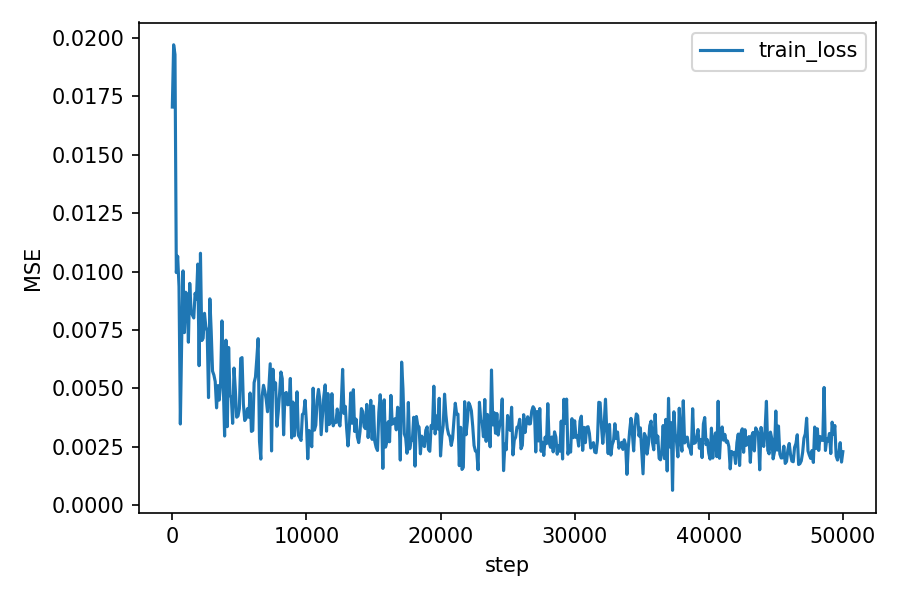

num recon imgs: 26


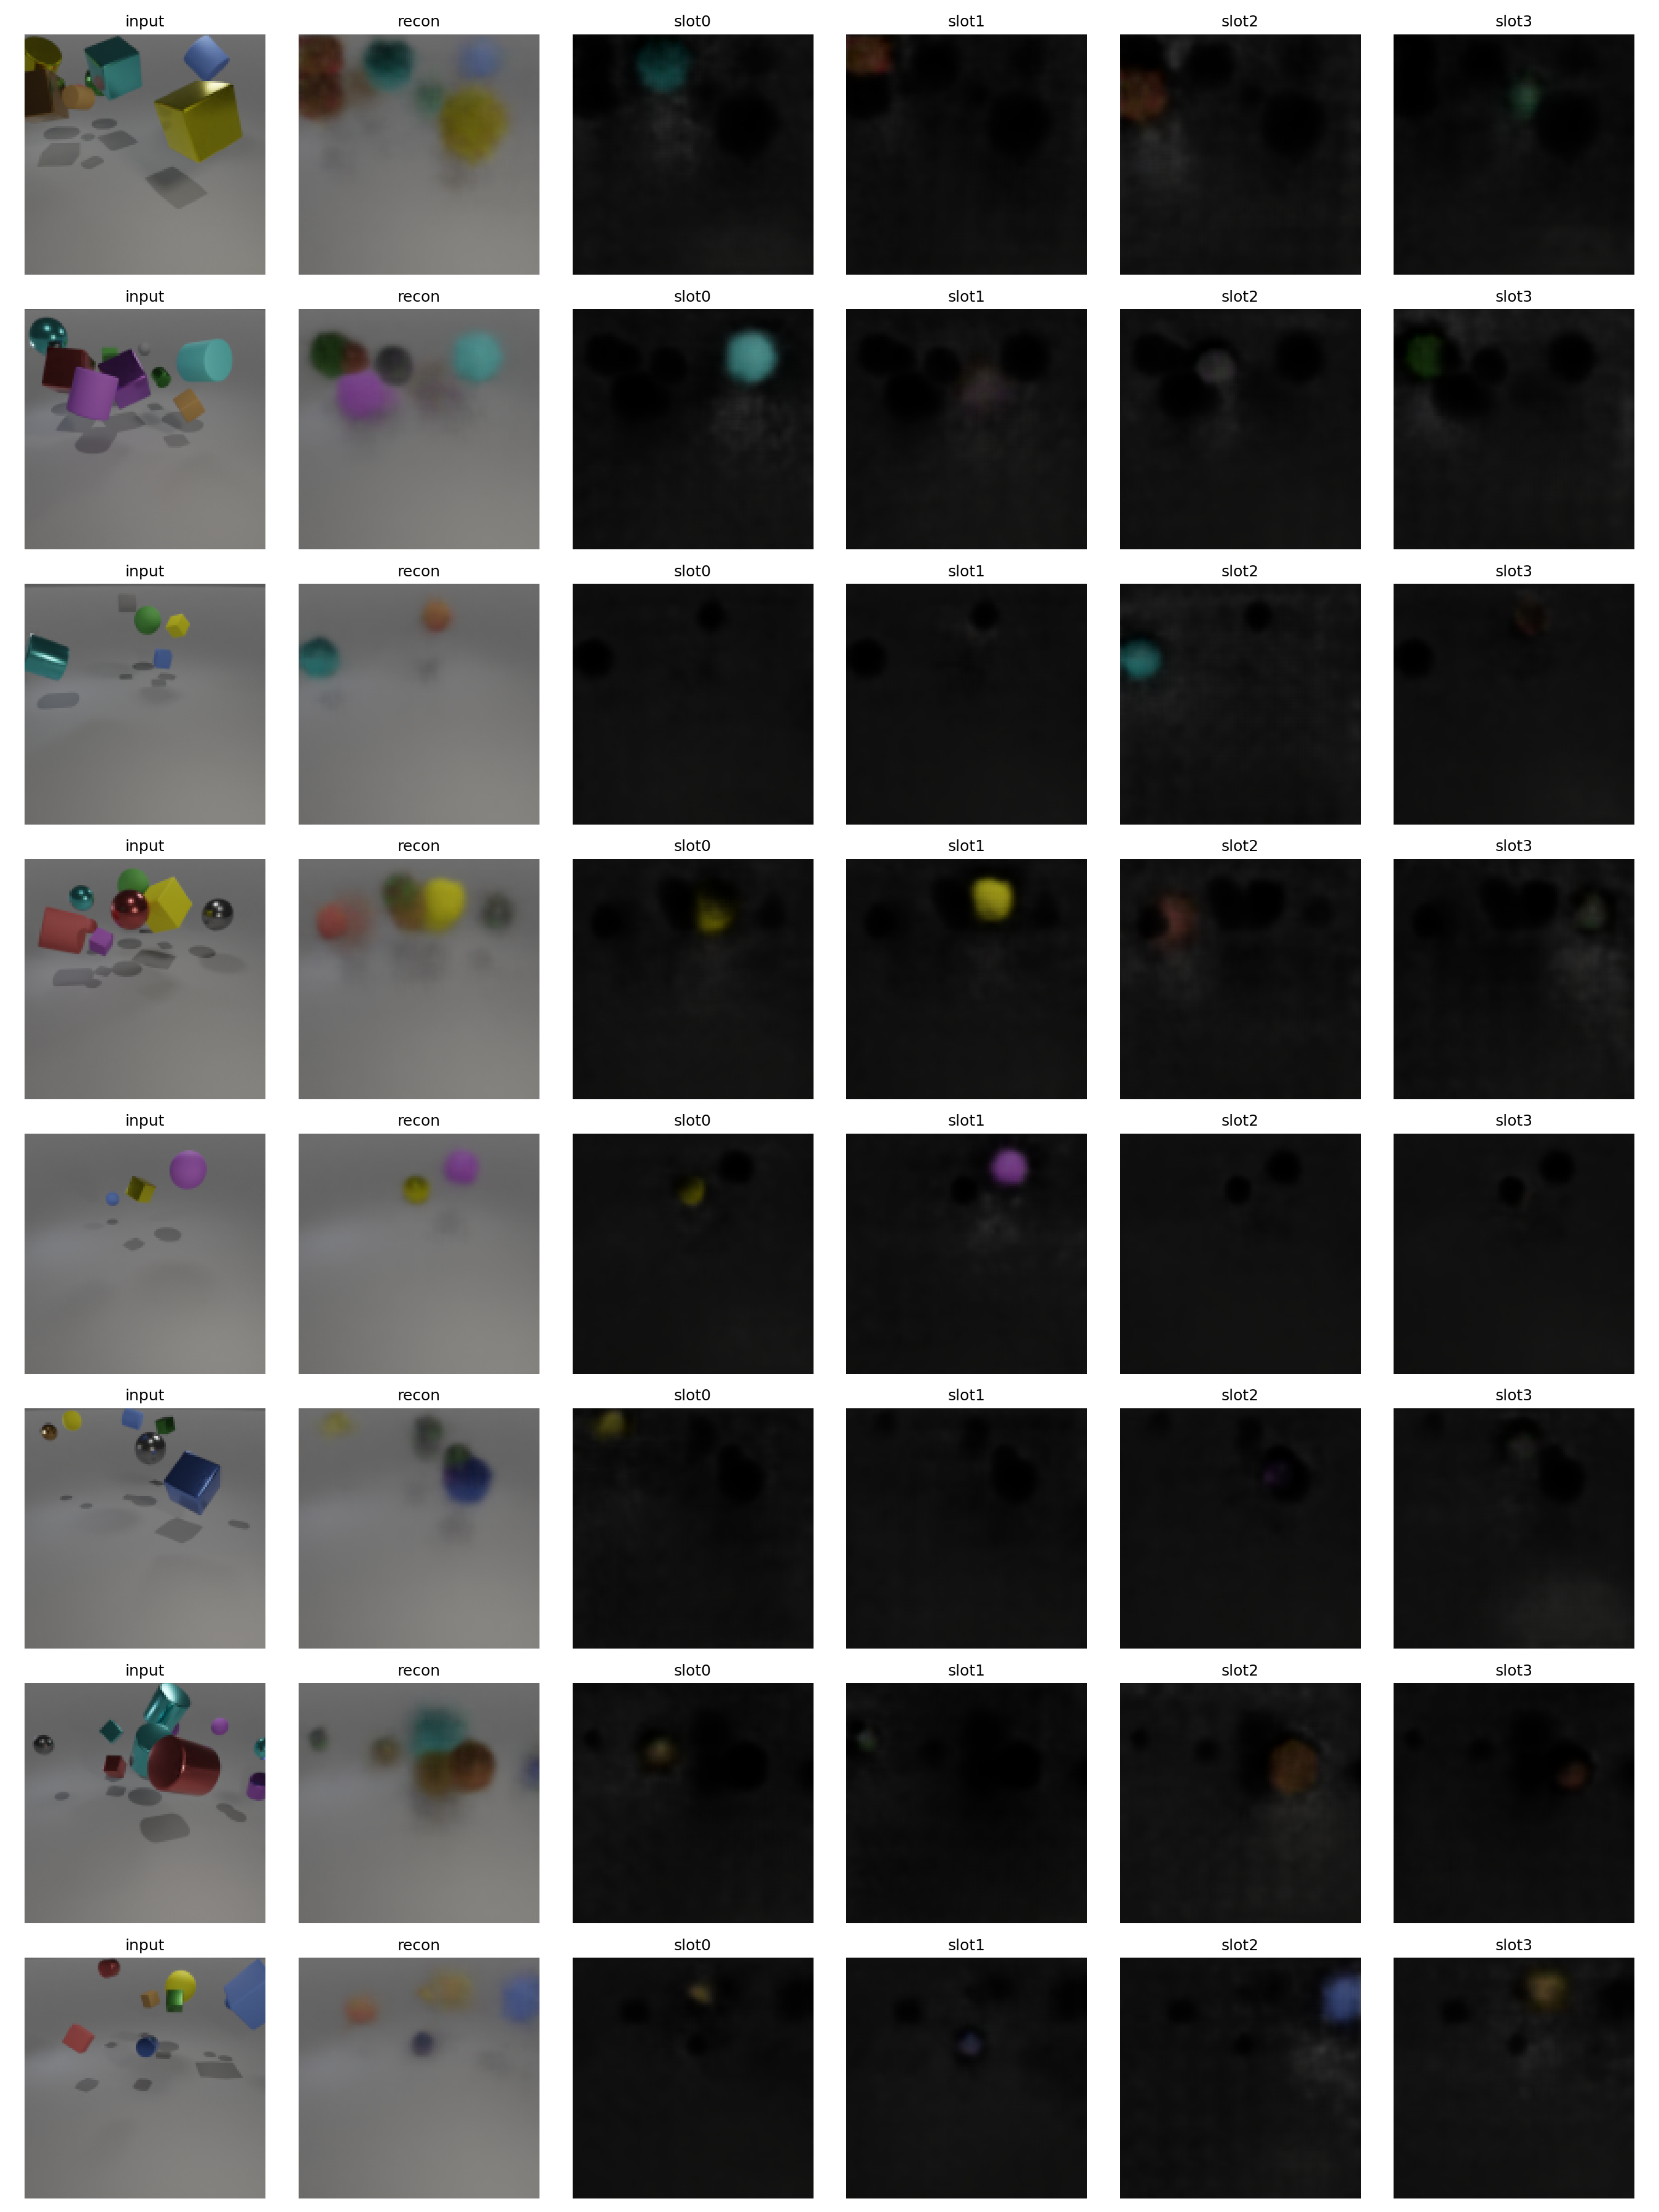

In [20]:
from PIL import Image
import glob

print("OUT_DIR:", OUT_DIR)

# 損失曲線
curve = os.path.join(OUT_DIR, "loss_curve.png")
if os.path.exists(curve):
    display(Image.open(curve))

# 最新 recon
recon_imgs = sorted(glob.glob(os.path.join(OUT_DIR, "recon_step*.png")))
print("num recon imgs:", len(recon_imgs))
if len(recon_imgs) > 0:
    display(Image.open(recon_imgs[-1]))
else:
    # 途中保存前なら初期図だけあるはず
    init_img = os.path.join(OUT_DIR, "recon_step000000.png")
    if os.path.exists(init_img):
        display(Image.open(init_img))

## 評価用パッケージ（Hungarian割当）

In [21]:
!pip -q install -U scipy
print("done")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 17.8 MB/s eta 0:00:00
done


## 動画シーケンス DataLoader（TFDS → 連続Tフレーム）

In [22]:
import numpy as np
import tensorflow_datasets as tfds
import torch
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader

class TFDSVideoSeqIterable(IterableDataset):
    """
    yields:
      x:  [T,3,H,W] float32 in [-1,1]
      gt: [T,H,W]   int64 instance-id map (if mask_key exists) else None
    """
    def __init__(self, tfds_dataset, video_key, mask_key=None, T=24, img_size=128,
                 start_mode="random", seed=0):
        super().__init__()
        self.ds = tfds_dataset
        self.video_key = video_key
        self.mask_key = mask_key
        self.T = T
        self.img_size = img_size
        self.start_mode = start_mode
        self.rng = np.random.RandomState(seed)

    def __iter__(self):
        for ex in tfds.as_numpy(self.ds):
            vid = ex[self.video_key]  # [Tv,H,W,3] uint8
            Tv = vid.shape[0]
            if Tv < self.T:
                continue

            if self.start_mode == "random":
                s = self.rng.randint(0, Tv - self.T + 1)
            else:
                s = 0

            clip = vid[s:s+self.T].astype(np.float32) / 255.0
            clip = clip * 2.0 - 1.0  # [-1,1]
            x = torch.from_numpy(clip).permute(0,3,1,2)  # [T,3,H,W]
            x = F.interpolate(x, size=(self.img_size, self.img_size), mode="bilinear", align_corners=False)

            if self.mask_key is not None and self.mask_key in ex:
                gt = ex[self.mask_key][s:s+self.T]
                if gt.ndim == 4 and gt.shape[-1] == 1:
                    gt = gt[...,0]
                gt = torch.from_numpy(gt.astype(np.int64))  # [T,H,W]
                gt = gt.unsqueeze(1).float()  # [T,1,H,W]
                gt = F.interpolate(gt, size=(self.img_size, self.img_size), mode="nearest").long()
                gt = gt.squeeze(1)  # [T,H,W]
                yield x.contiguous(), gt.contiguous()
            else:
                yield x.contiguous(), None

def make_video_loader(tfds_ds, batch_size=1, T=24, img_size=128, n_videos=64, seed=0):
    # まず評価は小さめに（安定＆速い）
    ds = tfds_ds.take(n_videos)
    it = TFDSVideoSeqIterable(ds, video_key=video_key, mask_key=mask_key, T=T, img_size=img_size,
                             start_mode="random", seed=seed)
    return DataLoader(it, batch_size=batch_size, num_workers=0, pin_memory=True)

EVAL_T = 24
EVAL_VIDEOS = 64
video_loader = make_video_loader(val_tfds if val_tfds is not None else train_tfds,
                                 batch_size=1, T=EVAL_T, img_size=IMG_SIZE, n_videos=EVAL_VIDEOS, seed=123)
print("video_loader ready")

video_loader ready


## Slot Attention を動画に適用（フレームごと）

In [23]:
import torch
import numpy as np

@torch.no_grad()
def run_model_on_clip(model, x_clip):
    """
    x_clip: [T,3,H,W] (torch, [-1,1])
    returns:
      masks: [T,K,H,W] float
      slots: [T,K,D]   float
    """
    model.eval()
    T = x_clip.shape[0]
    all_masks = []
    all_slots = []
    for t in range(T):
        x = x_clip[t:t+1].to(device, non_blocking=True)  # [1,3,H,W]
        recon, masks, rgb_slots, attn, slots = model(x)
        # masks: [1,K,1,H,W] -> [K,H,W]
        mt = masks[0,:,0].detach().cpu()
        st = slots[0].detach().cpu()
        all_masks.append(mt)
        all_slots.append(st)
    return torch.stack(all_masks, dim=0), torch.stack(all_slots, dim=0)

## 追跡（HungarianでスロットIDを時間で揃える）

In [24]:
from scipy.optimize import linear_sum_assignment

def soft_iou(a, b, eps=1e-8):
    # a,b: [H,W] float
    inter = torch.minimum(a, b).sum()
    union = torch.maximum(a, b).sum() + eps
    return (inter / union).item()

@torch.no_grad()
def track_slots_by_iou(masks_TKHW):
    """
    masks_TKHW: [T,K,H,W]
    returns:
      perm_TK: list of permutations per t (t>=1) mapping current slots -> tracked IDs
      tracked_masks: [T,K,H,W] aligned over time
    """
    T, K, H, W = masks_TKHW.shape
    tracked = [masks_TKHW[0]]  # [K,H,W]
    prev = masks_TKHW[0]

    perms = [np.arange(K)]
    for t in range(1, T):
        cur = masks_TKHW[t]

        # cost[i,j] = 1 - IoU(prev_i, cur_j)
        cost = np.zeros((K, K), dtype=np.float32)
        for i in range(K):
            for j in range(K):
                cost[i, j] = 1.0 - soft_iou(prev[i], cur[j])

        row, col = linear_sum_assignment(cost)  # row: prev idx, col: cur idx
        # We want cur aligned to prev order (tracked IDs)
        aligned = cur[col]  # [K,H,W] (tracked_id i corresponds to col[i])
        perms.append(col.copy())

        tracked.append(aligned)
        prev = aligned

    tracked_masks = torch.stack(tracked, dim=0)  # [T,K,H,W]
    return perms, tracked_masks

## GTありの場合：ID swap率（物体→スロット割当の入れ替わり）

In [25]:
def dominant_slot_for_object(gt_hw, tracked_masks_KHW, obj_id, min_pixels=50):
    """
    gt_hw: [H,W] int
    tracked_masks_KHW: [K,H,W] float
    return slot_id or None
    """
    obj = (gt_hw == obj_id)
    if obj.sum().item() < min_pixels:
        return None
    # overlap score = sum(mask * obj)
    scores = (tracked_masks_KHW * obj.float().unsqueeze(0)).sum(dim=(1,2))  # [K]
    return int(scores.argmax().item())

@torch.no_grad()
def id_swap_rate_for_clip(gt_THW, tracked_masks_TKHW, background_id=0, min_pixels=50):
    """
    gt_THW: [T,H,W] int
    tracked_masks_TKHW: [T,K,H,W] float (tracked)
    returns dict with swap_rate and details
    """
    T, K, H, W = tracked_masks_TKHW.shape
    swaps = 0
    transitions = 0
    per_obj = {}

    # 対象物体ID（最初のフレームから抽出でも良いが、全フレームで抽出）
    obj_ids = set()
    for t in range(T):
        ids = torch.unique(gt_THW[t]).tolist()
        for oid in ids:
            if oid != background_id:
                obj_ids.add(int(oid))
    obj_ids = sorted(list(obj_ids))

    for oid in obj_ids:
        last = None
        obj_swaps = 0
        obj_trans = 0
        for t in range(T):
            slot = dominant_slot_for_object(gt_THW[t], tracked_masks_TKHW[t], oid, min_pixels=min_pixels)
            if slot is None:
                continue
            if last is not None:
                obj_trans += 1
                if slot != last:
                    obj_swaps += 1
            last = slot
        if obj_trans > 0:
            per_obj[oid] = {"swaps": obj_swaps, "transitions": obj_trans, "swap_rate": obj_swaps/obj_trans}
            swaps += obj_swaps
            transitions += obj_trans

    swap_rate = (swaps / transitions) if transitions > 0 else None
    return {"swap_rate": swap_rate, "swaps": swaps, "transitions": transitions, "per_obj": per_obj}

## 自己一貫性（追跡slotのIoU維持）

In [26]:
@torch.no_grad()
def self_consistency_iou(tracked_masks_TKHW):
    """
    連続フレームの同一tracked slot間IoUの平均
    """
    T, K, H, W = tracked_masks_TKHW.shape
    vals = []
    for t in range(1, T):
        for k in range(K):
            vals.append(soft_iou(tracked_masks_TKHW[t-1,k], tracked_masks_TKHW[t,k]))
    return float(np.mean(vals)) if len(vals) else None

## 評価ループ（動画N本）→ 平均ID swap率 / 一貫性 を出力

In [27]:
import numpy as np

results = []
swap_rates = []
consistencies = []

for i, batch in enumerate(video_loader):
    x_clip, gt = batch
    x_clip = x_clip[0]            # [T,3,H,W]
    gt = gt[0] if gt is not None else None  # [T,H,W] or None

    masks_TKHW, slots_TKD = run_model_on_clip(model, x_clip)
    _, tracked_masks = track_slots_by_iou(masks_TKHW)

    cons = self_consistency_iou(tracked_masks)
    consistencies.append(cons)

    if gt is not None:
        out = id_swap_rate_for_clip(gt, tracked_masks, background_id=0, min_pixels=50)
        swap_rates.append(out["swap_rate"] if out["swap_rate"] is not None else np.nan)
        results.append({"video": i, "swap_rate": out["swap_rate"], "consistency_iou": cons,
                        "swaps": out["swaps"], "transitions": out["transitions"]})
    else:
        results.append({"video": i, "swap_rate": None, "consistency_iou": cons})

print("N videos:", len(results))
print("mean self-consistency IoU:", float(np.nanmean(consistencies)))

if len(swap_rates) > 0:
    print("mean ID swap rate:", float(np.nanmean(swap_rates)))

N videos: 64
mean self-consistency IoU: 0.8712824359478324
mean ID swap rate: 0.2147756730442439


## 可視化（追跡スロットの推移を動画っぽく見る）

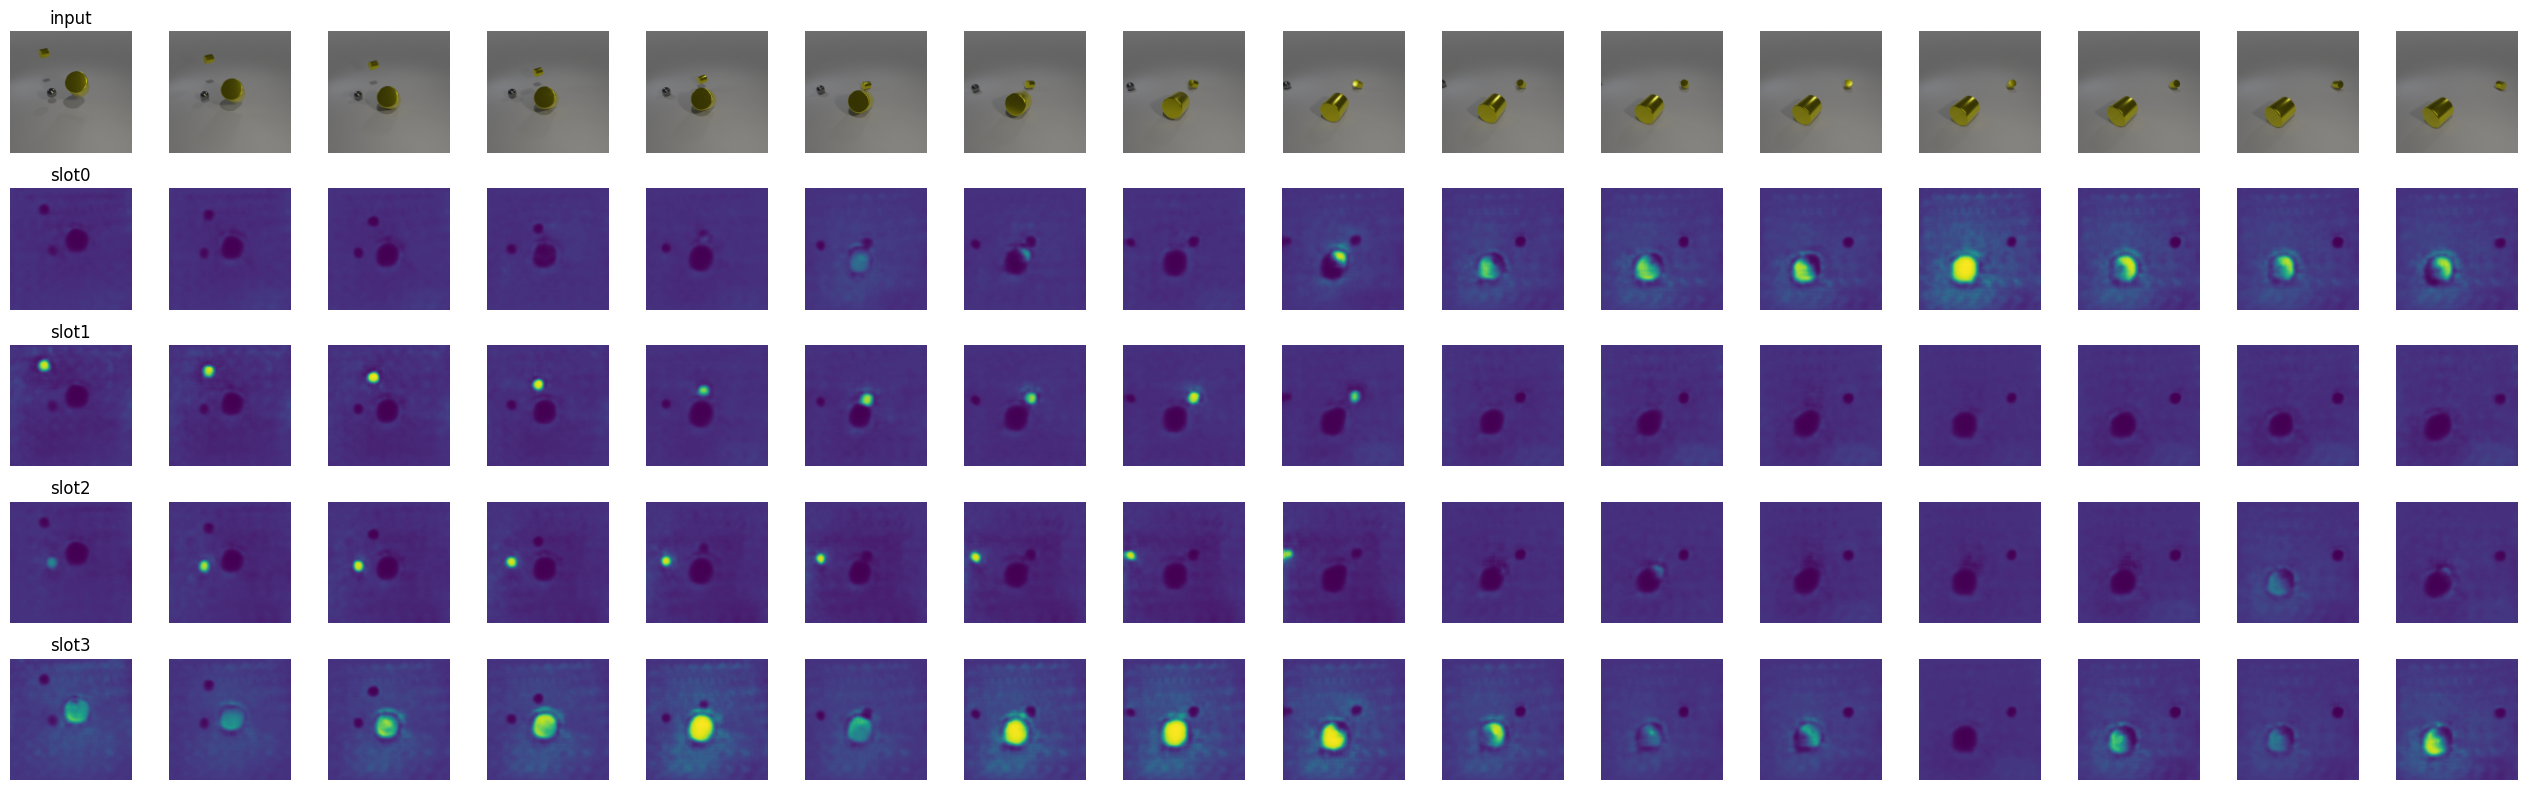

In [28]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_tracking_example(model, tfds_source, T=16, max_slots=4, seed=0):
    # 1 videoだけ取る
    it = TFDSVideoSeqIterable(tfds_source.take(1), video_key=video_key, mask_key=mask_key,
                             T=T, img_size=IMG_SIZE, start_mode="random", seed=seed)
    x_clip, gt = next(iter(it))
    masks_TKHW, _ = run_model_on_clip(model, x_clip)
    _, tracked = track_slots_by_iou(masks_TKHW)

    # display
    def denorm(x): return (x.clamp(-1,1)+1)/2
    x_np = denorm(x_clip).permute(0,2,3,1).cpu().numpy()  # [T,H,W,3]

    showK = min(tracked.shape[1], max_slots)
    fig, axes = plt.subplots(showK+1, T, figsize=(1.6*T, 1.6*(showK+1)))

    for t in range(T):
        axes[0, t].imshow(x_np[t])
        axes[0, t].axis("off")
        if t == 0: axes[0, t].set_title("input")

    for k in range(showK):
        for t in range(T):
            axes[1+k, t].imshow(tracked[t, k].cpu().numpy(), vmin=0, vmax=1)
            axes[1+k, t].axis("off")
            if t == 0: axes[1+k, t].set_title(f"slot{k}")

    plt.tight_layout()
    plt.show()

show_tracking_example(model, val_tfds if val_tfds is not None else train_tfds, T=16, max_slots=4, seed=0)

## 結果 results を DataFrame 化して保存（CSV）

In [29]:
import os, json
import numpy as np
import pandas as pd

# results: 既に作成済み（list of dict）を想定
df = pd.DataFrame(results)

# swap_rate が None の場合は NaN
if "swap_rate" in df.columns:
    df["swap_rate"] = pd.to_numeric(df["swap_rate"], errors="coerce")
if "consistency_iou" in df.columns:
    df["consistency_iou"] = pd.to_numeric(df["consistency_iou"], errors="coerce")

display(df.head())

# 保存先（OUT_DIR がある想定。無ければ /content/results_eval を作る）
EVAL_OUT = OUT_DIR if "OUT_DIR" in globals() else "/content/results_eval"
os.makedirs(EVAL_OUT, exist_ok=True)

csv_path = os.path.join(EVAL_OUT, "video_eval_summary.csv")
df.to_csv(csv_path, index=False)
print("saved:", csv_path)

,video,swap_rate,consistency_iou,swaps,transitions
0,0,0.118644,0.898226,7,59
1,1,0.228070,0.853674,39,171
2,2,0.130435,0.875203,12,92
3,3,0.144928,0.927838,10,69
4,4,0.014493,0.947292,1,69


saved: /content/results/slot_attention_moviA/20260122_024500/video_eval_summary.csv


## 全体サマリの可視化（ヒストグラム＋散布図）

In [30]:
import matplotlib.pyplot as plt

def save_fig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()
    print("saved:", path)

# 1) swap_rate ヒストグラム（GTありのとき）
if "swap_rate" in df.columns and df["swap_rate"].notna().any():
    plt.figure(figsize=(6,4))
    plt.hist(df["swap_rate"].dropna().values, bins=20)
    plt.xlabel("ID swap rate (lower is better)")
    plt.ylabel("count")
    plt.title("Distribution of ID swap rate")
    save_fig(os.path.join(EVAL_OUT, "hist_swap_rate.png"))
else:
    print("swap_rate is not available (GT mask_key is None or missing).")

# 2) consistency IoU ヒストグラム（GT無しでも可）
if "consistency_iou" in df.columns and df["consistency_iou"].notna().any():
    plt.figure(figsize=(6,4))
    plt.hist(df["consistency_iou"].dropna().values, bins=20)
    plt.xlabel("Self-consistency IoU (higher is better)")
    plt.ylabel("count")
    plt.title("Distribution of self-consistency IoU")
    save_fig(os.path.join(EVAL_OUT, "hist_consistency_iou.png"))

# 3) swap_rate vs consistency_iou 散布図（両方ある場合）
if ("swap_rate" in df.columns and df["swap_rate"].notna().any()
    and "consistency_iou" in df.columns and df["consistency_iou"].notna().any()):
    plt.figure(figsize=(6,5))
    d2 = df.dropna(subset=["swap_rate", "consistency_iou"])
    plt.scatter(d2["swap_rate"].values, d2["consistency_iou"].values, s=25)
    plt.xlabel("ID swap rate (↓)")
    plt.ylabel("Self-consistency IoU (↑)")
    plt.title("Swap rate vs Consistency")
    save_fig(os.path.join(EVAL_OUT, "scatter_swap_vs_consistency.png"))

saved: /content/results/slot_attention_moviA/20260122_024500/hist_swap_rate.png
saved: /content/results/slot_attention_moviA/20260122_024500/hist_consistency_iou.png
saved: /content/results/slot_attention_moviA/20260122_024500/scatter_swap_vs_consistency.png


## 動画ごとの折れ線（時系列ではなく “動画index” で並べて比較）

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# swap_rate の動画別プロット
if "swap_rate" in df.columns and df["swap_rate"].notna().any():
    plt.figure(figsize=(10,3))
    plt.plot(df["video"].values, df["swap_rate"].values, marker="o", linewidth=1)
    plt.xlabel("video index")
    plt.ylabel("ID swap rate")
    plt.title("ID swap rate per video")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    path = os.path.join(EVAL_OUT, "line_swap_rate_per_video.png")
    plt.savefig(path, dpi=150)
    plt.close()
    print("saved:", path)

# consistency_iou の動画別プロット
if "consistency_iou" in df.columns and df["consistency_iou"].notna().any():
    plt.figure(figsize=(10,3))
    plt.plot(df["video"].values, df["consistency_iou"].values, marker="o", linewidth=1)
    plt.xlabel("video index")
    plt.ylabel("self-consistency IoU")
    plt.title("Self-consistency IoU per video")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    path = os.path.join(EVAL_OUT, "line_consistency_per_video.png")
    plt.savefig(path, dpi=150)
    plt.close()
    print("saved:", path)

saved: /content/results/slot_attention_moviA/20260122_024500/line_swap_rate_per_video.png
saved: /content/results/slot_attention_moviA/20260122_024500/line_consistency_per_video.png


## 1本の動画をGIF保存（入力＋tracked masks）

In [32]:
!pip -q install -U imageio
print("done")

done


In [38]:
# ===== GIF生成に必要な関数を全部まとめて再定義（順番実行で落ちない） =====
!pip -q install -U imageio
import os
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import torch

# 必須チェック
assert "model" in globals(), "model が未定義です（学習済みモデルを用意してください）"
assert "train_tfds" in globals(), "train_tfds が未定義です（データロードセルを先に実行）"
assert "video_key" in globals(), "video_key が未定義です"
if "val_tfds" not in globals():
    val_tfds = None
if "IMG_SIZE" not in globals():
    IMG_SIZE = 128
if "device" not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# もし mask_key が未定義でもOK
if "mask_key" not in globals():
    mask_key = None

# もし EVAL_OUT が未定義なら作る
if "EVAL_OUT" not in globals():
    EVAL_OUT = "/content/results_eval"
    os.makedirs(EVAL_OUT, exist_ok=True)

# --- クリップ取り出し（TFDS） ---
import tensorflow_datasets as tfds
import torch.nn.functional as F

class TFDSVideoSeqIterable:
    def __init__(self, tfds_dataset, video_key, mask_key=None, T=16, img_size=128, seed=0):
        self.ds = tfds_dataset
        self.video_key = video_key
        self.mask_key = mask_key
        self.T = T
        self.img_size = img_size
        self.rng = np.random.RandomState(seed)

    def __iter__(self):
        for ex in tfds.as_numpy(self.ds):
            vid = ex[self.video_key]  # [Tv,H,W,3]
            Tv = vid.shape[0]
            if Tv < self.T:
                continue
            s = self.rng.randint(0, Tv - self.T + 1)
            clip = vid[s:s+self.T].astype(np.float32)/255.0
            clip = clip*2.0 - 1.0
            x = torch.from_numpy(clip).permute(0,3,1,2)  # [T,3,H,W]
            x = F.interpolate(x, size=(self.img_size,self.img_size), mode="bilinear", align_corners=False)

            if self.mask_key is not None and self.mask_key in ex:
                gt = ex[self.mask_key][s:s+self.T]
                if gt.ndim == 4 and gt.shape[-1] == 1:
                    gt = gt[...,0]
                gt = torch.from_numpy(gt.astype(np.int64))
                gt = gt.unsqueeze(1).float()
                gt = F.interpolate(gt, size=(self.img_size,self.img_size), mode="nearest").long().squeeze(1)
                yield x.contiguous(), gt.contiguous()
            else:
                yield x.contiguous(), None

@torch.no_grad()
def run_model_on_clip(model, x_clip):
    model.eval()
    all_masks = []
    for t in range(x_clip.shape[0]):
        x = x_clip[t:t+1].to(device, non_blocking=True).float()
        recon, masks, rgb_slots, attn, slots = model(x)
        # masks: [1,K,1,H,W] -> [K,H,W]
        all_masks.append(masks[0,:,0].detach().cpu())
    return torch.stack(all_masks, dim=0)  # [T,K,H,W]

from scipy.optimize import linear_sum_assignment

def soft_iou(a, b, eps=1e-8):
    inter = torch.minimum(a, b).sum()
    union = torch.maximum(a, b).sum() + eps
    return (inter/union).item()

@torch.no_grad()
def track_slots_by_iou(masks_TKHW):
    T, K, H, W = masks_TKHW.shape
    tracked = [masks_TKHW[0]]
    prev = masks_TKHW[0]
    for t in range(1, T):
        cur = masks_TKHW[t]
        cost = np.zeros((K,K), dtype=np.float32)
        for i in range(K):
            for j in range(K):
                cost[i,j] = 1.0 - soft_iou(prev[i], cur[j])
        row, col = linear_sum_assignment(cost)
        aligned = cur[col]
        tracked.append(aligned)
        prev = aligned
    return torch.stack(tracked, dim=0)

def denorm01(x):
    return (x.clamp(-1,1) + 1) / 2

def fig_to_uint8_rgb(fig):
    fig.canvas.draw()
    buf = np.asarray(fig.canvas.buffer_rgba())  # (H,W,4)
    return buf[..., :3].copy()

@torch.no_grad()
def render_clip_frames(x_clip, tracked_masks, max_slots=4):
    T = x_clip.shape[0]
    K = tracked_masks.shape[1]
    showK = min(K, max_slots)

    x_np = denorm01(x_clip).permute(0,2,3,1).cpu().numpy()

    frames = []
    for t in range(T):
        fig, axes = plt.subplots(1, 1+showK, figsize=(3*(1+showK), 3))
        axes[0].imshow(x_np[t]); axes[0].set_title(f"input t={t}"); axes[0].axis("off")
        for k in range(showK):
            mk = tracked_masks[t,k].cpu().numpy()
            axes[1+k].imshow(mk, vmin=0, vmax=1)
            axes[1+k].set_title(f"slot{k}")
            axes[1+k].axis("off")
        plt.tight_layout()
        frames.append(fig_to_uint8_rgb(fig))
        plt.close(fig)
    return frames

@torch.no_grad()
def save_tracking_gif(model, tfds_source, out_gif, T=16, max_slots=4, seed=0, fps=6):
    it = TFDSVideoSeqIterable(tfds_source.take(1), video_key=video_key, mask_key=mask_key,
                             T=T, img_size=IMG_SIZE, seed=seed)
    x_clip, gt = next(iter(it))
    masks_TKHW = run_model_on_clip(model, x_clip)
    tracked = track_slots_by_iou(masks_TKHW)
    frames = render_clip_frames(x_clip, tracked, max_slots=max_slots)
    imageio.mimsave(out_gif, frames, fps=fps)
    print("saved gif:", out_gif)

print("save_tracking_gif is ready ✅  EVAL_OUT=", EVAL_OUT)

save_tracking_gif is ready ✅  EVAL_OUT= /content/results/slot_attention_moviA/20260122_024500


In [39]:
gif_path = os.path.join(EVAL_OUT, "tracking_example.gif")
save_tracking_gif(model, val_tfds if val_tfds is not None else train_tfds,
                  gif_path, T=16, max_slots=4, seed=0, fps=6)

saved gif: /content/results/slot_attention_moviA/20260122_024500/tracking_example.gif


In [40]:
from IPython.display import Image, display
display(Image(filename=gif_path))

Output hidden; open in https://colab.research.google.com to view.

In [41]:
import glob, os

files = sorted(glob.glob(os.path.join(EVAL_OUT, "*")))
print("Saved files:")
for f in files:
    print(" -", f)

Saved files:
 - /content/results/slot_attention_moviA/20260122_024500/config.json
 - /content/results/slot_attention_moviA/20260122_024500/hist_consistency_iou.png
 - /content/results/slot_attention_moviA/20260122_024500/hist_swap_rate.png
 - /content/results/slot_attention_moviA/20260122_024500/line_consistency_per_video.png
 - /content/results/slot_attention_moviA/20260122_024500/line_swap_rate_per_video.png
 - /content/results/slot_attention_moviA/20260122_024500/loss_curve.png
 - /content/results/slot_attention_moviA/20260122_024500/metrics.csv
 - /content/results/slot_attention_moviA/20260122_024500/recon_step000000.png
 - /content/results/slot_attention_moviA/20260122_024500/recon_step002000.png
 - /content/results/slot_attention_moviA/20260122_024500/recon_step004000.png
 - /content/results/slot_attention_moviA/20260122_024500/recon_step006000.png
 - /content/results/slot_attention_moviA/20260122_024500/recon_step008000.png
 - /content/results/slot_attention_moviA/20260122_02450